In [1]:
!pip install datasets
!pip install -q emoji pythainlp sklearn-pycrfsuite seqeval
!pip install tensorflow deepcut

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pythainlp.tokenize import word_tokenize
from datasets import load_dataset, load_metric, DatasetDict, Dataset, load_from_disk

In [5]:
dataset = load_from_disk('/content/drive/MyDrive/Fake news/News-Dataset/augmented_dataset')

In [6]:
def tokenizer(text):
  return word_tokenize(text,engine="deepcut")

In [7]:
tokenizer(dataset['train']['text'][0])

['วิธี',
 'ทำ',
 'หัวปลีกล้วยน้ำว้า',
 'กับ',
 'สูตร',
 'แก้',
 'โรค',
 'เบาหวาน',
 '|',
 '|',
 '|',
 'วิธี',
 'ทำ',
 'หัวปลีกล้วยน้ำว้า',
 'กับ',
 'สูตร',
 'แก้',
 'โรค',
 'เบาหวาน',
 'หัว',
 'ปลีกล้วยน้ำว้า',
 'กับ',
 'สูตร',
 'แก้',
 'โรค',
 'เบาหวาน',
 'มี',
 'วิธี',
 'ทำ',
 'รับประทาน',
 'เอง',
 'แบบ',
 'ง่าย',
 'ๆ',
 'คือ',
 'ให้',
 'เอา',
 'หัว',
 'ปลีกล้วยน้ำ',
 'ว้า',
 'เท่า',
 'นั้น',
 'หัว',
 'ปลี',
 'จาก',
 'กล้วย',
 'ชนิด',
 'อื่น',
 'ใช้',
 'ไม่',
 'ได้',
 'จำนวน',
 '1',
 'หัวย่างไฟ',
 'ให้',
 'เปลือก',
 'ชั้น',
 'นอก',
 'ไหม้',
 'เกรียม',
 'แล้ว',
 'ต้ม',
 'กับ',
 'น้ำ',
 'กะ',
 'จำนวน',
 'พอเหมาะ',
 'จน',
 'เดือด',
 'ดื่ม',
 'ต่าง',
 'น้ำ',
 'ทั้ง',
 'วัน',
 'ให้',
 'หมด',
 'หม้อ',
 'วัน',
 'ละ',
 '1',
 'หัว',
 'จน',
 'ครบ',
 '7',
 'วัน',
 'หาก',
 'คน',
 'ที่',
 'เป็น',
 'เบาหวาน',
 'ดื่ม',
 'แล้ว',
 'ถูก',
 'ทาง',
 'ยา',
 'ดื่ม',
 '1',
 '-',
 '2',
 'วัน',
 'แรก',
 'จะ',
 'มี',
 'อาการ',
 'รู้สึก',
 'ปวด',
 'เมื่อย',
 'ตาม',
 'ร่างกาย',
 'แทบ',
 'ทน',
 'ไม่',
 'ไหว',
 '

In [8]:
#เปลี่ยนข้อความเป็น bag-of-words features
tfidf = TfidfVectorizer(ngram_range=(1,2), tokenizer=word_tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)

In [9]:
x_train = tfidf.fit_transform(dataset['train']['text']+dataset['valid']['text'])
x_test = tfidf.transform(dataset['test']['text'])
x_train,x_test

(<5130x115364 sparse matrix of type '<class 'numpy.float64'>'
 	with 2616817 stored elements in Compressed Sparse Row format>,
 <676x115364 sparse matrix of type '<class 'numpy.float64'>'
 	with 328595 stored elements in Compressed Sparse Row format>)

In [10]:
enc = LabelEncoder()
y_train = enc.fit_transform(np.array(dataset['train']['labels'] + dataset['valid']['labels']))
y_valid = enc.transform(np.array(dataset['valid']['labels']))
y_test = enc.transform(np.array(dataset['test']['labels']))
y_train.shape, y_valid.shape, y_test.shape

((5130,), (270,), (676,))

In [11]:
# https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LR', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['true', 'fake']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

In [13]:
x_train

<5130x115364 sparse matrix of type '<class 'numpy.float64'>'
	with 2616817 stored elements in Compressed Sparse Row format>

In [14]:
final = run_exps(x_train,y_train,x_test,y_test)

LR
              precision    recall  f1-score   support

        true       0.91      0.88      0.89       304
        fake       0.90      0.93      0.92       372

    accuracy                           0.91       676
   macro avg       0.91      0.90      0.90       676
weighted avg       0.91      0.91      0.91       676

RF
              precision    recall  f1-score   support

        true       0.89      0.87      0.88       304
        fake       0.89      0.91      0.90       372

    accuracy                           0.89       676
   macro avg       0.89      0.89      0.89       676
weighted avg       0.89      0.89      0.89       676

KNN
              precision    recall  f1-score   support

        true       0.87      0.88      0.87       304
        fake       0.90      0.89      0.89       372

    accuracy                           0.88       676
   macro avg       0.88      0.88      0.88       676
weighted avg       0.88      0.88      0.88       676

SVM
     

In [15]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

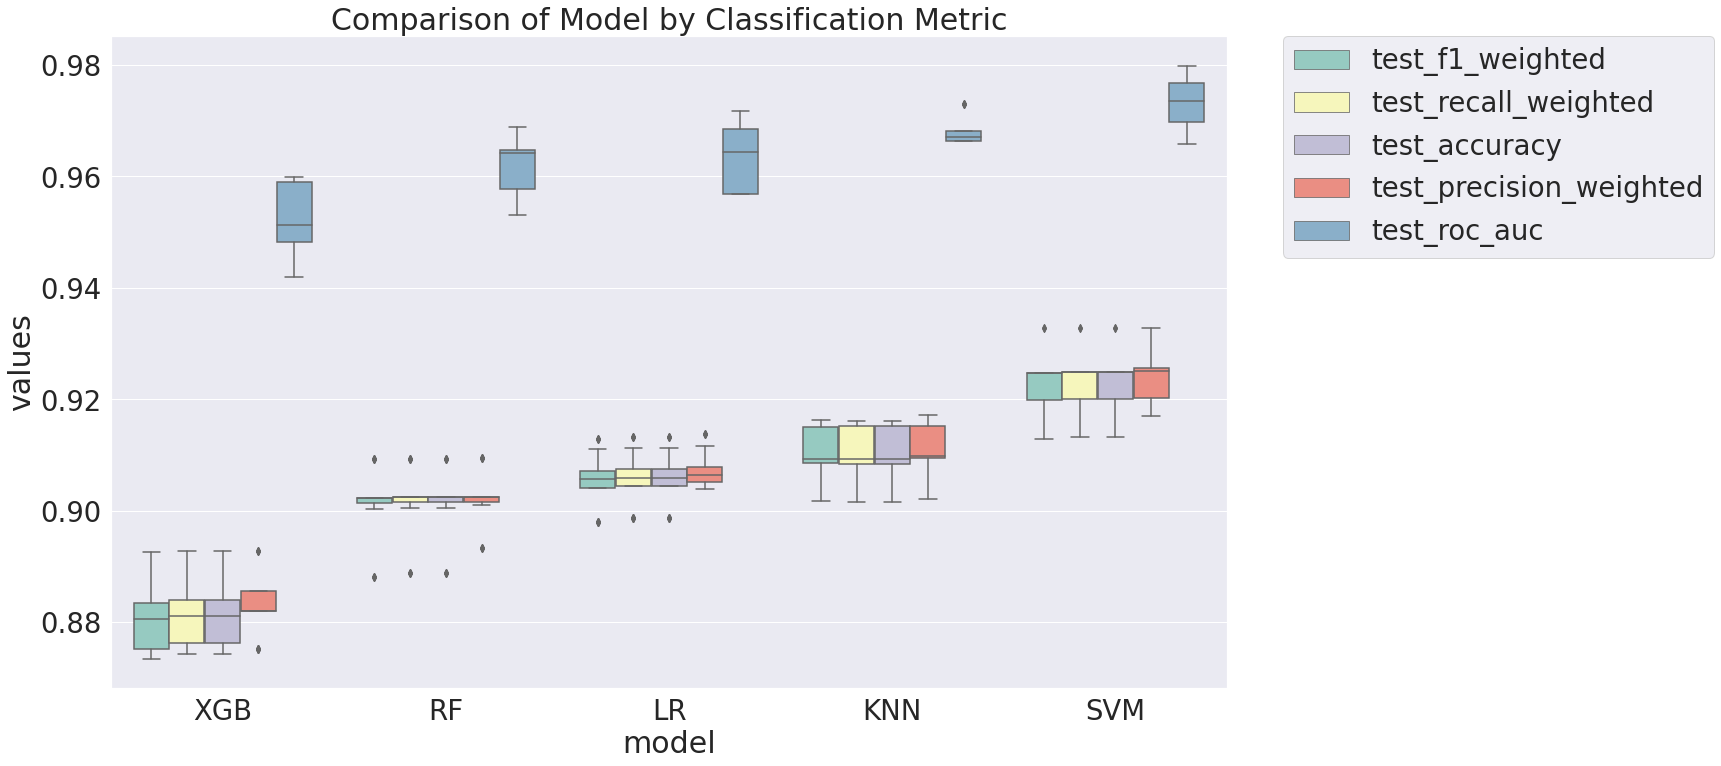

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

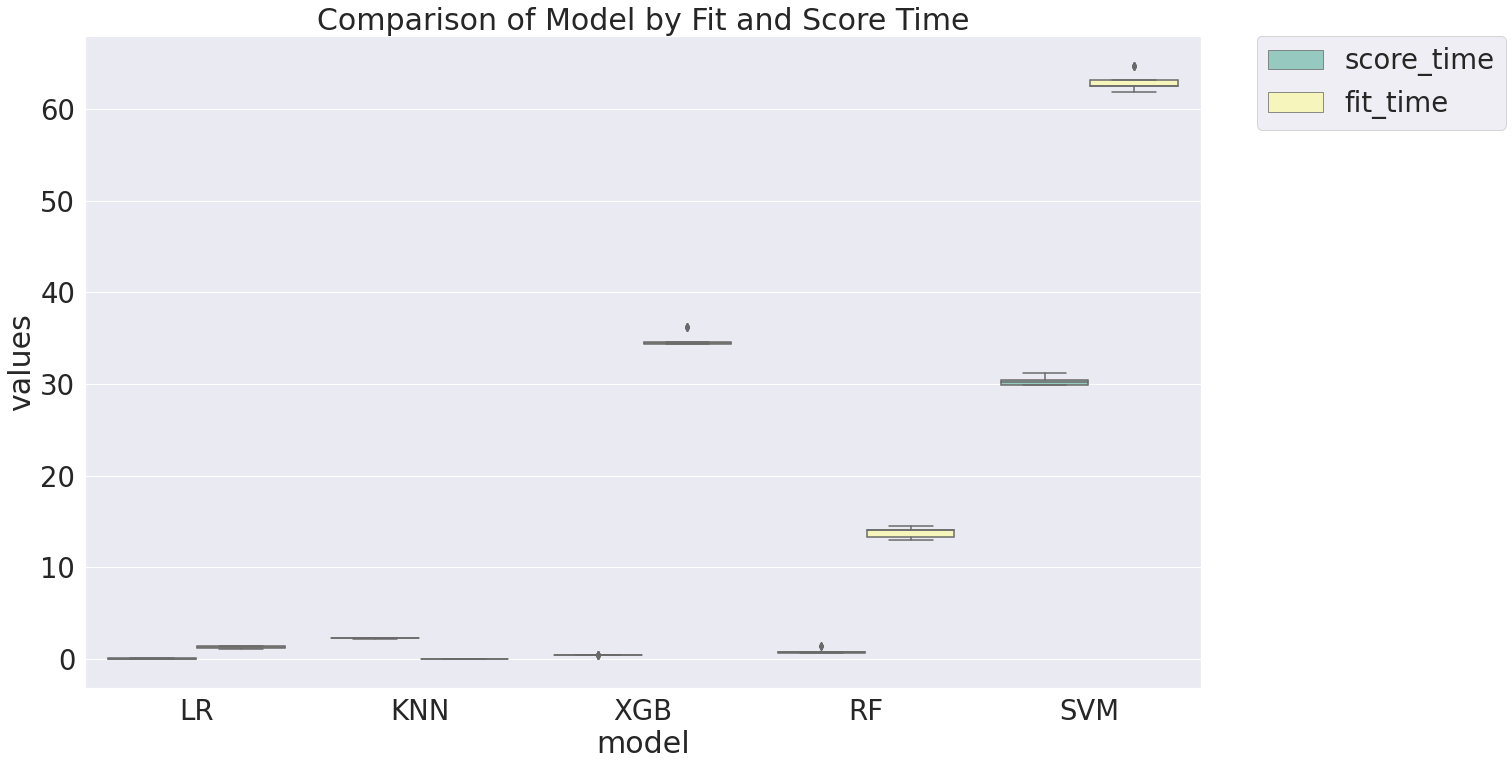

In [17]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [18]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_accuracy           test_precision_weighted           test_roc_auc  \
                std      mean                     std      mean          std   
model                                                                          
KNN        0.005524  0.909812                0.005430  0.910381     0.002167   
LR         0.004759  0.905945                0.003382  0.907406     0.005793   
RF         0.005750  0.901429                0.004487  0.902099     0.005651   
SVM        0.004859  0.923099                0.003957  0.923781     0.004130   
XGB        0.006069  0.880409                0.005395  0.882442     0.006591   

                test_recall_weighted           test_f1_weighted            
           mean                  std      mean              std      mean  
model                                                                      
KNN    0.967753             0.005524  0.909812         0.005454  0.909843  
LR     0.963669             0.004759  0.905945         0.004922  0.905586  
RF     0.961600             0.005750  0.901429         0.005933  0.901168  
SVM    0.972910             0.004859  0.923099         0.004962  0.922913  
XGB    0.950817             0.006069  0.880409         0.006335  0.879758

In [19]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time            score_time           
            std       mean        std       mean
model                                           
KNN    0.000154   0.024081   0.026117   2.239322
LR     0.110804   1.256354   0.008021   0.020962
RF     0.567793  13.819979   0.257204   0.772251
SVM    1.067693  62.955774   0.510117  30.296166
XGB    0.750424  34.863013   0.018981   0.375654